In [5]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from collections import Counter
from vit_keras import vit
from vit_keras import visualize
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import cv2



In [16]:
# import datatset
IMAGE_SIZE = 384
BATCH_SIZE = 6
EPOCHS = 100

TRAIN_PATH = "C:/Users/FYP/Documents/eyedata/400x400/train"
TEST_PATH = "C:/Users/FYP/Documents/eyedata/400x400/test"

DF_TRAIN = pd.read_csv("C:/Users/FYP/Documents/eyedata/train.csv", dtype='str')
TEST_IMAGES = glob.glob(TEST_PATH + '/*.jpeg')
DF_TEST = pd.DataFrame(TEST_IMAGES, columns = ['image_path'])

In [22]:
# class weights
weights = {0: 0.2721948519236092,
 1: 2.8755555555555556,
 2: 1.3275377969762419,
 3: 8.047790507364976,
 4: 9.913709677419355}

In [ ]:
def preprocessing(img):
    shape = img.shape[0]/2
    x = img[int(shape)].sum(1)
    radius=(x>x.mean()/10).sum()/2
    final=IMAGE_SIZE*1.0/radius
    img = cv2.resize(img,(0,0),fx=final,fy=final)
    colour = cv2.addWeighted(img, 4, cv2.GaussianBlur(img,(0,0), IMAGE_SIZE/30), -4, 128)
    colour = cv2.resize(colour, (IMAGE_SIZE,IMAGE_SIZE))
    return colour

In [17]:
#importing images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          validation_split = 0.3,
                                                          preprocessing_function = preprocessing()
)

train_gen = datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                        directory = TRAIN_PATH,
                                        x_col = 'image_id',
                                        y_col = 'label',
                                        subset = 'training',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))
                                        
valid_gen = datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                        directory = TRAIN_PATH,
                                        x_col = 'image_id',
                                        y_col = 'label',
                                        subset = 'validation',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_gen = datagen.flow_from_dataframe(dataframe = DF_TEST,
                                       x_col = 'image_path',
                                       y_col = None,
                                       batch_size = BATCH_SIZE,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE))


Found 24587 validated image filenames belonging to 5 classes.
Found 10537 validated image filenames belonging to 5 classes.
Found 53572 validated image filenames.


In [18]:
# call the vit model
vit_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

In [19]:
# create the vit model
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, 'softmax')
    ],
    name = 'vision_transformer')

In [ ]:
# define learning rate
learning_rate = 1e-4

#define optimiser
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

#compile model
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

#save model every iteration where accuracy increases
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1)

callbacks = [checkpoint]

history = model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks
        #   class_weight=weights
        )

# model.save('vit.h5')

In [ ]:
# plotting accuracy and loss graphs for the model
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
#provide the prediciton based on the vaidation set
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  


print("Accuracy on testing data: %2.2f%% " % (accuracy_score(true_classes,predicted_classes)))
print(classification_report(true_classes, predicted_classes))

Text(33.0, 0.5, 'Actual Label')

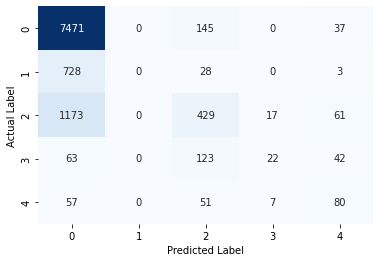

In [14]:
# plot the confusion matrix
confusion = sns.heatmap(confusion_matrix(true_classes,predicted_classes), annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues)
confusion.set_xlabel("Predicted Label", fontsize = 10)
confusion.set_ylabel("Actual Label", fontsize = 10)

In [15]:
# retreive the cohen's kappa score
cohen_kappa_score(true_classes, predicted_classes)

0.27860787414129884